 # 用于预训练Embedding的数据集

 这一步只是 构建了vocab，实现字符串和索引的转换 对每一个单词，构建了它的中心词索引、上下文索引和负样本的索引，并不涉及embedding

In [1]:
import collections
import math
import os
import random
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
print(os.getcwd())

d:\a_university\1.3MLDL\LMDL


In [3]:
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')
def read_ptb():
    """Load the PTB dataset into a list of text lines."""
    data_dir = d2l.download_extract('ptb')
    print(f"当前数据文件存放在{os.path.abspath(data_dir)}")
    # Read the training set
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()

当前数据文件存放在d:\a_university\1.3MLDL\LMDL\data\ptb


## 创建单词表
出现次数小于10次的单词将会被``<unk>``替代

In [4]:
print(f'# sentences: {len(sentences)}')
print(sentences[0:5])
print([len(sentence) for sentence in sentences[0:5]])
vocab = d2l.Vocab(sentences, min_freq=10)
print(f'vocab size: {len(vocab)}')

# sentences: 42069
[['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec', 'ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens', 'sim', 'snack-food', 'ssangyong', 'swapo', 'wachter'], ['pierre', '<unk>', 'N', 'years', 'old', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', 'N'], ['mr.', '<unk>', 'is', 'chairman', 'of', '<unk>', 'n.v.', 'the', 'dutch', 'publishing', 'group'], ['rudolph', '<unk>', 'N', 'years', 'old', 'and', 'former', 'chairman', 'of', 'consolidated', 'gold', 'fields', 'plc', 'was', 'named', 'a', 'nonexecutive', 'director', 'of', 'this', 'british', 'industrial', 'conglomerate'], ['a', 'form', 'of', 'asbestos', 'once', 'used', 'to', 'make', 'kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group', 'of', 'workers', 'exposed', 'to', 'it', 'more', 'than', 'N', 'years', 'ago', 'researchers', 'repo

## downsample

对于那些出现得非常频繁的词，我们就有一定概率在训练时直接把它们“扔掉”，不参与训练。词出现的频率越高，被扔掉的概率就越大，被丢弃概率定义为
$$
P(w_i)=max(1-\sqrt{\frac{t}{f(w_i)}},0)
$$

In [5]:
'''
vocab对象具有__getitem__(self, tokens)，让你能像使用字典一样使用 vocab 对象。
vocab['apple'] 会返回 "apple" 对应的索引。如果 "apple" 不在词汇表中，它会返回未知词 <unk> 的索引。
它还能处理一个列表，vocab[['apple', 'banana']] 会返回 [索引1, 索引2]。

counter同样可以接受单词，返回该单词的出现次数
counter['apple']
'''
def subsample(sentences,vocab):
    sentences=[[token for token in line if vocab[token]!=vocab.unk]for line in sentences]
    counter=collections.Counter([token for line in sentences for token in line])# 注意这两个for的不一样
    num_tokens=sum(counter.values())
    def keep(token):
        return (random.uniform(0,1)<math.sqrt(1e-4/counter[token]*num_tokens))
    return ([[token for token in line if keep(token)]for line in sentences],counter)
subsampled,counter=subsample(sentences,vocab)
print(len(subsampled))
print([len(sentence) for sentence in subsampled[0:5]])

42069
[0, 5, 4, 8, 16]


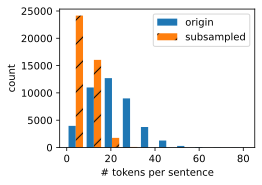

In [6]:
d2l.show_list_len_pair_hist(['origin', 'subsampled'], '# tokens per sentence',
                            'count', sentences, subsampled)

In [7]:
def compare_counts(token,sentences,subsampled):
    return (f'# of "{token}": '
            f'before={sum([l.count(token) for l in sentences])}, '
            f'after={sum([l.count(token) for l in subsampled])}')
print(compare_counts('the',sentences,subsampled))
print(compare_counts('intel',sentences,subsampled))
print(counter['intel'])

# of "the": before=50770, after=2067
# of "intel": before=44, after=44
44


## 创建corpus
corpus将文本数据数值化，即将单词转换成它们在词汇表（vocab）中对应的整数索引。

In [8]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [6612, 3228, 416, 1773, 4060], [3178, 3922, 1922, 4743]]

##  提取中心词汇和上下文词汇
The following get_centers_and_contexts function extracts all the center words and their context words from corpus. It uniformly samples an integer between 1 and max_window_size at random as the context window size. 


In [10]:
mylist=['2','b']
list1=['1','a']
mylist+=list1
mylist.append(list1)
mylist

['2', 'b', '1', 'a', ['1', 'a']]

In [11]:
def get_centers_and_contexts(corpus,max_window_size):
    centers,contexts=[],[]
    for line in corpus:
        if len(line)<2:
            continue
        centers+=line
        for i in range(len(line)):
            window_size=random.randint(1,max_window_size)
            indices=list(range(max(0,i-window_size),min(len(line),i+window_size+1)))
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers,contexts
# centers是一维列表，(句子数*每个句子单词数)
# contexts是二维列表，(句子数*每个句子单词数，每个单词的上下文数)

In [12]:
all_centers,all_contexts = get_centers_and_contexts(corpus, 5)
print (all_centers[0:10])
print(all_contexts[0:10])
f'# center-context pairs: {sum([len(contexts) for contexts in all_contexts])}'

[6612, 3228, 416, 1773, 4060, 3178, 3922, 1922, 4743, 2462]
[[3228, 416], [6612, 416, 1773, 4060], [6612, 3228, 1773, 4060], [3228, 416, 4060], [6612, 3228, 416, 1773], [3922, 1922, 4743], [3178, 1922, 4743], [3178, 3922, 4743], [3178, 3922, 1922], [993, 1325, 2641, 2340]]


'# center-context pairs: 1497586'

## Negative Sampling

In [13]:
class RandomGenerator:
    """
    sampling weights记录了每个单词被抽中的概率
    draw本质上就是按照概率返回一个单词的索引，但是每次调用random.choices比较慢，所以先调用10000次生成列表，然后每次从列表里取就好了
    """
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

In [14]:
def get_negatives(all_contexts,vocab,counter,k):
    #根据word2vec论文中的建议，将噪声的采样概率设置为其在字典中的相对频率的0.75次方
    sampling_weights=[counter[vocab.to_tokens(i)]**0.75 for i in range (1,len(vocab))]
    all_negatives,generator=[],RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives=[]
        # 对于一个正例，我们随机抽取了K个（实验中为5个）噪声词
        while len(negatives)<len(contexts)*k:
            neg=generator.draw()
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives
all_negatives = get_negatives(all_contexts, vocab, counter, 5)
# all_negatives是二维列表，(句子数*每个句子单词数，每个单词的上下文数)

在小批量中，第i个样本包括中心词及个上下文词和噪声词。由于上下文窗口大小不同，对于不同的i，上下文词和噪声词的个数是不同的。因此，对于每个样本，我们在contexts_negatives个变量中将其上下文词和噪声词连结起来，并填充零，直到连结长度达到(max_len)。

为了在计算损失时排除填充，我们定义了掩码变量masks。在masks中的元素和contexts_negatives中的元素之间存在一一对应关系，其中masks中的0（否则为1）对应于contexts_negatives中的填充。

为了区分正反例，我们在contexts_negatives中通过一个labels变量将上下文词与噪声词分开。类似于masks，在labels中的元素和contexts_negatives中的元素之间也存在一一对应关系，其中labels中的1（否则为0）对应于contexts_negatives中的上下文词的正例，labels为0对应噪声词或填充的0.

In [15]:
# 这个函数传给构建data_iter的，由dataset传每个数据data，data_iter对每个data调用这个函数
def batchify(data):
    """
    data包括了中心词和它的上下文词和噪声词all_centers,all_contexts,all_negatives
    返回带有负采样的跳元模型的小批量样本"""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += \
            [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [16]:
class PTBDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
        assert len(centers) == len(contexts) == len(negatives)
        self.centers = centers
        self.contexts = contexts
        self.negatives = negatives

    def __getitem__(self, index):
        return (self.centers[index], self.contexts[index],
                self.negatives[index])

    def __len__(self):
        return len(self.centers)
def load_data_ptb(batch_size,max_window_size,num_noise):
    #num_workers=d2l.get_dataloader_workers()
    num_workers=0
    sentences=read_ptb()
    vocab=d2l.Vocab(sentences,min_freq=10)
    subsampled,counter=subsample(sentences,vocab)
    corpus=[vocab[line]for line in subsampled]
    all_centers,all_contexts=get_centers_and_contexts(corpus,max_window_size)
    all_negatives=get_negatives(all_contexts,vocab,counter,num_noise)
    dataset=PTBDataset(all_centers,all_contexts,all_negatives)
    data_iter=torch.utils.data.DataLoader(dataset,batch_size,shuffle=True,collate_fn=batchify,num_workers=num_workers)
    return data_iter,vocab
max_window=5
num_noise=5
data_iter, vocab = load_data_ptb(512, max_window, num_noise)
names=['centers','contexts_negatives','masks','labels']
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    print(f"后三项的列数为 窗口大小两倍{max_window}*2+每个上下文词对应有的噪声词{max_window}*2*{num_noise}")
    break
    

当前数据文件存放在d:\a_university\1.3MLDL\LMDL\data\ptb
centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])
后三项的列数为 窗口大小两倍5*2+每个上下文词对应有的噪声词5*2*5


# 预训练word2vec

In [17]:
embed_size=100
net=nn.Sequential(nn.Embedding(num_embeddings=len(vocab),embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),embedding_dim=embed_size))

In [18]:
'''
embd_v/_u为两个embedding层，(vocab_size,embed_dims)，给定索引，能够返回对应的嵌入向量

'''
def skip_gram(center,contexts_and_negatives,embd_v,embd_u):
    v=embd_v(center) # center(batch_size,1),v(batch_size,embed_dims)
    u=embd_u(contexts_and_negatives) # u(batch_size,max_len,embed_dims)
    pred=torch.bmm(v,u.permute(0,2,1))# (batch_size,1,max_len)
    return pred
# pred要和label做with_logits的交叉熵，要reshanpe成label的形状（batch_size,max_len)

In [19]:
'''
reduction : str, optional
Specifies the reduction to apply to the output:
        ``'none'``: no reduction will be applied,
        ``'mean'``: the sum of the output will be divided by the number of elements in the output, 
        ``'sum'``: the output will be summed. Note: :attr:`size_average`
        and :attr:`reduce` are in the process of being deprecated, and in the meantime,
        specifying either of those two args will override :attr:`reduction`. 
        Default: ``'mean'``
'''
class SigmoidBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,inputs,target,mask):
        #print(inputs,target,mask)
        out=nn.functional.binary_cross_entropy_with_logits(inputs,target,weight=mask,reduction='none')
        #print(out.shape)
        return out.mean(dim=1)
loss=SigmoidBCELoss()

loss0.3271


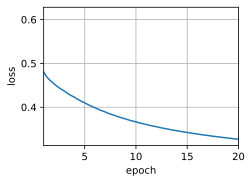

In [20]:
def train(net,data_iter,lr,num_epochs,device=d2l.try_gpu()):
    def init_weights(module):
        if type(module)==nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net=net.to(device)
    optimizer=torch.optim.Adam(net.parameters(),lr=lr)
    animatior=d2l.Animator(xlabel='epoch',ylabel='loss',xlim=[1,num_epochs])
    metric=d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer,num_batches=d2l.Timer(),len(data_iter)
        for i,batch in enumerate(data_iter):
            optimizer.zero_grad()
            center,context_negative,mask,label=[data.to(device) for data in batch]
            pred=skip_gram(center,context_negative,net[0],net[1])
            l=(loss(pred.reshape(label.shape).float(),label.float(),mask)/mask.sum(axis=1)*mask.shape[1])# 因为loss平均值是包含了0的，因为有mask=0的部分，要乘上个比例
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(),l.numel())
            if (i+1)%(num_batches//5)==0 or i==num_batches-1:
                animatior.add(epoch+(i+1)/num_batches,(metric[0]/metric[1],))
    print(f'loss{metric[0]/metric[1]:.4f}')

lr,num_epochs=0.002,20
train(net,data_iter,lr,num_epochs)

In [21]:
'''
torch.topk 返回一个元组 (values, indices)，values 是相似度得分，indices 是这些单词在词汇表中的索引，我们只需要索引
'''
def get_similar_tokens(vocab,embed,query_token,k):
    W=embed.weight.data
    x=W[vocab[query_token]]
    cos=torch.mv(W,x)/torch.sqrt(torch.sum(W*W,dim=1)*torch.sum(x*x)+1e-9)
    topk=torch.topk(cos,k=k+1)[1].cpu().numpy().astype('int32')# 返回k+1个因为第0个永远是它本身
    for i in topk[:]:# 我们也把第0个词打印一下，看看它是否为unk
        print(f'cosine sim={float(cos[i]):.3f}:{vocab.to_tokens(i)}')

get_similar_tokens(vocab,net[0],'university',5)

cosine sim=1.000:university
cosine sim=0.495:professor
cosine sim=0.472:foundation
cosine sim=0.457:researcher
cosine sim=0.443:laboratory
cosine sim=0.440:thomas
